Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 9935.8750 - mae: 65.5598 - val_loss: 8342.9473 - val_mae: 52.1181
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7138.5024 - mae: 54.0932 - val_loss: 8333.5518 - val_mae: 52.0152
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9534.8750 - mae: 62.9795 - val_loss: 8324.3848 - val_mae: 51.9157
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8764.2070 - mae: 60.8719 - val_loss: 8315.6318 - val_mae: 51.8157
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8751.4082 - mae: 59.6912 - val_loss: 8306.8418 - val_mae: 51.7161
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9232.9648 - mae: 60.6289 - val_loss: 8298.5547 - val_mae: 51.6219
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7936.7925 - mae: 57.8909 - val_loss: 8289.9619 - val_mae: 51.5299
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9546.3408 - mae: 62.6756 - val_loss: 8280.8506 - val_mae: 51.4348
Epoch 9/50
3/3 ━

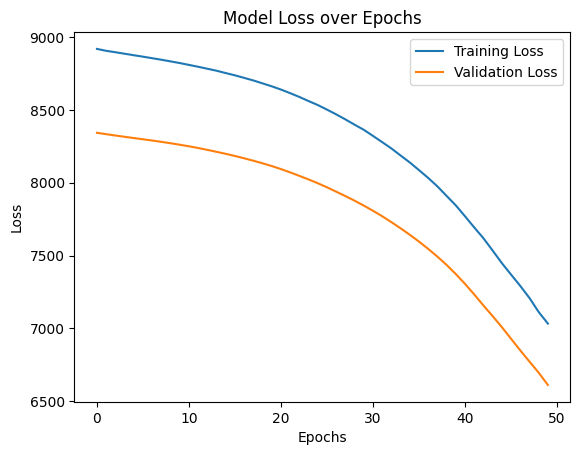

interactive(children=(FloatSlider(value=1.6741456588767654, description='Width (m)', max=2.9247746304049858, m…

<function __main__.interactive_mesh_grid(width, length, wing_angle)>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step/step

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
from ipywidgets import interact, widgets

#------------

# Step 1: Load the dataset
file_path = r"C:/Users/david/OneDrive/Documents/YasAi/Schulung KI/Beispiele/wing_downforce_con.csv"  # Update this path
df = pd.read_csv(file_path)

# Step 2: Drop constant columns (like Speed, Cd_downforce, Cd_drag) if they exist in your new data
df = df.drop(columns=['Speed (m/s)', 'Cd_downforce', 'Cd_drag'])  # Adjust these column names as per your dataset

# Step 3: Split data into 70% training and 30% temporary (test + validation)
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42)

# Step 4: Split the temporary data into 20% test and 10% validation
test_data, validation_data = train_test_split(temp_data, test_size=1/3, random_state=42)

# Step 5: Separate the features (X) and target (y)
X_train = train_data.drop(columns=["Downforce (N)"])  # Features
y_train = train_data["Downforce (N)"]  # Target

X_test = test_data.drop(columns=["Downforce (N)"])
y_test = test_data["Downforce (N)"]

X_val = validation_data.drop(columns=["Downforce (N)"])
y_val = validation_data["Downforce (N)"]

# Step 6: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

#------------


# Step 7: Define the Keras model with an explicit Input layer
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression (predicting downforce)
])

# Step 8: Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 9: Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Step 10: Plot the training and validation loss (static graph)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

#--------


# Step 11: Interactive 3D mesh grid visualization with predicted downforce
def interactive_mesh_grid(width, length, wing_angle):
    # Define the range of values for Width (m) and Wing Angle (degrees)
    width_range = np.linspace(X_train['Width (m)'].min(), X_train['Width (m)'].max(), 100)
    angle_range = np.linspace(X_train['Wing Angle (degrees)'].min(), X_train['Wing Angle (degrees)'].max(), 100)
    width_grid, angle_grid = np.meshgrid(width_range, angle_range)

    # Flatten the grid and prepare the input for the model
    flat_width = width_grid.flatten()
    flat_angle = angle_grid.flatten()

    # Use the length provided by the slider
    length_constant = length

    # Prepare the input features for prediction
    grid_input = pd.DataFrame({
        'Width (m)': flat_width,
        'Length (m)': np.full_like(flat_width, length_constant),
        'Wing Angle (degrees)': flat_angle
    })

    # Scale the input features
    grid_input_scaled = scaler.transform(grid_input)

    # Predict the downforce for each point in the grid
    downforce_pred = model.predict(grid_input_scaled)

    # Reshape the predictions back to the shape of the mesh grid
    downforce_grid = downforce_pred.reshape(width_grid.shape)

    # Step 12: Plot the mesh grid
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(width_grid, angle_grid, downforce_grid, cmap='viridis')

    # Set labels
    ax.set_xlabel('Width (m)')
    ax.set_ylabel('Wing Angle (degrees)')
    ax.set_zlabel('Predicted Downforce (N)')

    plt.title(f'Predicted Downforce for Length = {length:.2f} m')
    plt.show()

    # Step 13: Predict downforce for the selected sliders' values
    input_data = pd.DataFrame({
        'Width (m)': [width],
        'Length (m)': [length],
        'Wing Angle (degrees)': [wing_angle]
    })

    # Scale the input data
    input_data_scaled = scaler.transform(input_data)

    # Predict the downforce
    predicted_downforce = model.predict(input_data_scaled)
    
    # Print the predicted downforce
    print(f"\nPredicted Downforce for Width = {width:.2f} m, Length = {length:.2f} m, Wing Angle = {wing_angle:.2f}°: {predicted_downforce[0][0]:.2f} N")

# Step 14: Create interactive sliders for all three parameters
width_slider = widgets.FloatSlider(min=X_train['Width (m)'].min(), max=X_train['Width (m)'].max(), step=0.01, value=X_train['Width (m)'].mean(), description='Width (m)')
length_slider = widgets.FloatSlider(min=X_train['Length (m)'].min(), max=X_train['Length (m)'].max(), step=0.01, value=X_train['Length (m)'].mean(), description='Length (m)')
angle_slider = widgets.FloatSlider(min=X_train['Wing Angle (degrees)'].min(), max=X_train['Wing Angle (degrees)'].max(), step=0.1, value=X_train['Wing Angle (degrees)'].mean(), description='Wing Angle (°)')

# Step 15: Use the interact function to create an interactive mesh grid visualization
interact(interactive_mesh_grid, width=width_slider, length=length_slider, wing_angle=angle_slider)
